# High-Level Corpus Stats

In [21]:
import os
import glob

from tqdm.auto import tqdm
from dotenv import load_dotenv
import PyPDF2
import fitz
import pandas as pd
import seaborn as sns

load_dotenv()
CORPUS_PATH = os.getenv("CORPUS_PATH")

CORPUS_PATH

'/Users/kalyan/Documents/CPR/policy-search/data/corpus/content'

## 1. File formats

In [2]:
possible_extensions = [".html", ".HTML", ".htm", ".HTM", ".pdf", ".PDF",]

files_with_ext = dict()

for ext in possible_extensions:
    files_with_ext[ext] = glob.glob(f"{CORPUS_PATH}/*{ext}")
    print(f"{len(files_with_ext[ext])} files with extension {ext}")

3378 files with extension .html
0 files with extension .HTML
0 files with extension .htm
0 files with extension .HTM
2824 files with extension .pdf
0 files with extension .PDF


## 2. PDF Analysis

### Number of pages per PDF

In [3]:
num_pages = dict()

for fname in tqdm(files_with_ext[".pdf"] + files_with_ext[".PDF"]):
    with open(fname, "rb") as f:
        try:
            num_pages[fname] = PyPDF2.PdfFileReader(f, strict=False).numPages
        except Exception as e:
            num_pages[fname] = f"Exception: {e}"
    

  0%|          | 0/2824 [00:00<?, ?it/s]

TOTAL NO PAGES: 166247


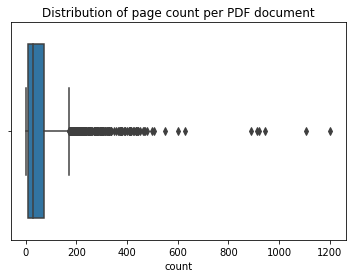

In [20]:
page_count_df = pd.DataFrame.from_dict({k:v for k,v in num_pages.items() if not str(v).startswith("Exception")}, orient="index").rename(columns={0: "count"})
print(f"TOTAL NO PAGES: {page_count_df['count'].sum()}")
sns.boxplot(x=page_count_df['count']).set_title("Distribution of page count per PDF document");

In [61]:
page_count_df['count'].describe()

count    2770.000000
mean       60.016968
std        88.794479
min         1.000000
25%        10.000000
50%        28.000000
75%        74.000000
max      1202.000000
Name: count, dtype: float64

### Scanned vs Non-scanned

Here we check to see whether there's text embedded in each PDF.

In [37]:
def has_embedded_text(doc: fitz.Document) -> bool:
    for page in doc:
        if page.getText():
            return True
        
    return False

embedded_text = dict()

for fname in tqdm(files_with_ext[".pdf"] + files_with_ext[".PDF"]):
    with fitz.open(fname) as doc:
        embedded_text[fname] = has_embedded_text(doc)
            

  0%|          | 0/2824 [00:00<?, ?it/s]

Deprecation: 'getText' removed from class 'Page' after v1.19 - use 'get_text'.
mupdf: expected object number
mupdf: expected object number
mupdf: expected generation number (0 ? obj)
mupdf: expected object number
mupdf: No default Layer config
mupdf: No default Layer config
mupdf: expected object number
mupdf: expected object number
mupdf: expected object number
mupdf: cannot find startxref
mupdf: expected object number
mupdf: cmsOpenProfileFromMem failed
mupdf: No default Layer config
mupdf: expected object number
mupdf: expected object number
mupdf: cmsOpenProfileFromMem failed
mupdf: cannot find startxref
mupdf: invalid key in dict
mupdf: cmsOpenProfileFromMem failed
mupdf: expected object number
mupdf: cannot find startxref
mupdf: expected object number
mupdf: No default Layer config
mupdf: expected object number
mupdf: cannot find startxref
mupdf: expected object number
mupdf: expected object number
mupdf: cannot find startxref
mupdf: expected object number
mupdf: expected object 

In [46]:
emb_text_df = pd.DataFrame.from_dict(embedded_text, orient="index").rename(columns={0: "has_embedded_text"})
emb_text_count = emb_text_df.reset_index().groupby("has_embedded_text").count().rename(columns={"index": "count"})
emb_text_count['percent'] = emb_text_count['count'] / emb_text_count['count'].sum() * 100

emb_text_count

,count,percent
has_embedded_text,,
False,152,5.382436
True,2672,94.617564


In [48]:
emb_text_df[emb_text_df['has_embedded_text'] == True].sample(10)

,has_embedded_text
/Users/kalyan/Documents/CPR/policy-search/data/corpus/content/cpd-4415-c46887610b404c2f8bb3fd3a4d075034.pdf,True
/Users/kalyan/Documents/CPR/policy-search/data/corpus/content/cclw-8699-1a7ed1aa1a2943578452f21f6ca394fb.pdf,True
/Users/kalyan/Documents/CPR/policy-search/data/corpus/content/cclw-8536-824a447245404ec1ba6104a707f14a1b.pdf,True
/Users/kalyan/Documents/CPR/policy-search/data/corpus/content/cclw-9496-3f0dfa47ac5f4a3aa5d03a624c43799d.pdf,True
/Users/kalyan/Documents/CPR/policy-search/data/corpus/content/cclw-1699-2b527b1461444e4f93470620027c94b0.pdf,True
/Users/kalyan/Documents/CPR/policy-search/data/corpus/content/cclw-1497-cb3e1724ee7947d2a29eed3e4b19d8a1.pdf,True
/Users/kalyan/Documents/CPR/policy-search/data/corpus/content/cclw-9017-78b643f969c240f39a8bde2a13c3dd8f.pdf,True
/Users/kalyan/Documents/CPR/policy-search/data/corpus/content/cclw-8553-c8880adffce24819b52610891c2fbdd7.pdf,True
/Users/kalyan/Documents/CPR/policy-search/data/corpus/content/cclw-1372-6c29db31dc974b2792f00a1bf37fddca.pdf,True
/Users/kalyan/Documents/CPR/policy-search/data/corpus/content/cclw-8813-f06cb543008047c79b8b33a923814fb1.pdf,True


## Presence of bookmarks and contents page metadata

In [57]:
contents_page = dict()
has_contents_page = dict()

for fname in tqdm(files_with_ext[".pdf"] + files_with_ext[".PDF"]):
    with fitz.open(fname) as doc:
        toc = doc.get_toc(simple=False)
        contents_page[fname] = toc
        has_contents_page[fname] = bool(toc) 

  0%|          | 0/2824 [00:00<?, ?it/s]

mupdf: expected object number
mupdf: expected object number
mupdf: expected generation number (0 ? obj)
mupdf: expected object number
mupdf: expected object number
mupdf: expected object number
mupdf: expected object number
mupdf: cannot find startxref
mupdf: expected object number
mupdf: expected object number
mupdf: expected object number
mupdf: cannot find startxref
mupdf: invalid key in dict
mupdf: expected object number
mupdf: cannot find startxref
mupdf: expected object number
mupdf: expected object number
mupdf: cannot find startxref
mupdf: expected object number
mupdf: expected object number
mupdf: cannot find startxref
mupdf: expected object number
mupdf: expected object number
mupdf: expected object number
mupdf: expected object number
mupdf: cannot find startxref
mupdf: cannot find startxref
mupdf: expected object number
mupdf: expected object number
mupdf: xref subsection length missing
mupdf: cannot find startxref
mupdf: expected object number
mupdf: expected object number

In [60]:
contents_page_df = pd.DataFrame.from_dict(has_contents_page, orient="index").rename(columns={0: "has_contents_page"})
contents_page_count = contents_page_df.reset_index().groupby("has_contents_page").count().rename(columns={"index": "count"})
contents_page_count['percent'] = contents_page_count['count'] / contents_page_count['count'].sum() * 100

contents_page_count

,count,percent
has_contents_page,,
False,2418,85.623229
True,406,14.376771


In [72]:
contents_page["/Users/kalyan/Documents/CPR/policy-search/data/corpus/content/cclw-9112-5a84badb44ce408a9bbef6703e868274.pdf"][0][-1]

{'kind': 1,
 'xref': 21,
 'page': 0,
 'to': Point(61.0, 71.0),
 'zoom': 0.0,
 'collapse': True}

In [81]:
def contents_uses_coords(contents):
    """
    Determine whether contents page uses coordinates (points to a place within a page), or just points to a page.
    Bookmarks that point to a coordinate in a page could be a useful source of labels for section headings.
    """
    
    for bookmark in contents:
        if bookmark[-1].get("to"):
            if bookmark[-1].get("to").y != 0: 
                return True 
        elif bookmark[-1].get("kind") == 2:
            # Means the link points to a named position in the document.
            # https://pymupdf.readthedocs.io/en/latest/vars.html#linkdest-kinds
            return True
        
    return False


In [86]:
contents_page_stats = []

for filename, contents in tqdm(contents_page.items()):
    if contents:
        try:
            contents_page_stats.append({
                "filename": filename,
                "contents_length": len(contents),
                "contents_uses_coords": contents_uses_coords(contents),
            })
        except:
            print(f"{filename} failed")


  0%|          | 0/2824 [00:00<?, ?it/s]

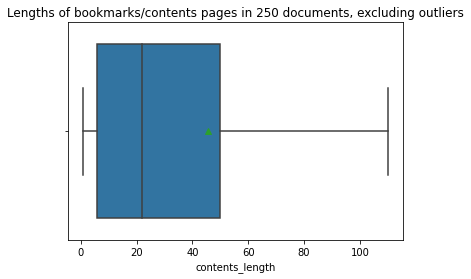

In [100]:
sns.boxplot(
    x=pd.DataFrame(contents_page_stats)["contents_length"], 
    showfliers=False, 
    showmeans=True).set_title("Lengths of bookmarks/contents pages in 250 documents, excluding outliers");


Text(0.5, 1.0, "Distribution of 'contents page length'/'page count'")

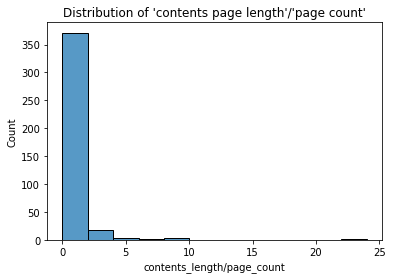

In [123]:
contents_page_df = pd.DataFrame(contents_page_stats).set_index("filename")
contents_page_df = pd.concat([contents_page_df, page_count_df], axis=1, ignore_index=False).rename(columns={"count": "page_count"}).dropna(subset=["contents_length"])

contents_page_df["contents_length/page_count"] = contents_page_df["contents_length"] / contents_page_df["page_count"]

sns.histplot(x=contents_page_df["contents_length/page_count"], binwidth=2).set_title("Distribution of 'contents page length'/'page count'")